Ilaria Enache 

Computer Vision and Machine Learning Lab

Link to the shared folder with all the data and datasets: https://drive.google.com/drive/folders/1caU3qpKqAhUKdmhJ0nLzWYzRu1ZAh1Y5?usp=sharing

Importing useful libraries

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
import time
import random

import io
import cv2 # OpenCV library

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.models import model_from_json

We start by testing if the camera is working and define the VideoCapture function to capture the images for the project. 

In [2]:
# VideoCapture creates a real time video stream 

def VideoCapture():
  js = Javascript('''
    // the function 'create' creates the "box" that contains the videostream
    // async functions return a promise, they make the code look synchronous, but it's asynchronous and non-blocking behind the scenes
    async function create(){ 
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      // await is used to call functions, the calling code will stop until the promise is resolved or rejected
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      // await is used to call functions, here we call the video.play() function
      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    //  
    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.80);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)


VideoCapture()
eval_js('create()')

image_max_width = 640
image_max_height = 480

<IPython.core.display.Javascript object>

In [3]:
#access google drive to use files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Given a variable byte containing the bytes of an image, returns an array representing the image
def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

In [5]:
#Given an array representing an image, returns the byte associated with the image
def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [6]:
def detect(img, cascade):
  # rects represent the coordinates of the rectangles containing different objects
  rects = cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  if len(rects) == 0: # if no rectangles are found, return the empty list
    return []  
  rects[:,2:] += rects[:,:2] #(x1,y1,x2,y2) we have the top left and bottom right corners of the rectangle

  return rects

In [7]:
#draw the rects on the video
def draw_rects(img, rects, color, size=2):
  for x1, y1, x2, y2 in rects:
    cv2.rectangle(img, (x1, y1), (x2, y2), color, size)

# **Task 1** 

In this first task, I identified the face using a Haarcascade over a converted grayscale image. 
I used a gray image as they have less information to process, improving speed and efficiency compared to detection over a colored image. 

The region of interest is then identified and drawn with the coordinates identified in the detect function. 
It is important to note that the image is defined from the top left at 0 ,0 to the bottom right.



In [8]:
# detect face and eyes using the Haar Feature-based Cascade Classifiers

VideoCapture() #starts the VideoCapture function
eval_js('create()') #utilizes the given JS code

image_max_width = 640
image_max_height = 480

#application of the Haarcascade for object detection faces
CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
  e1 = cv2.getTickCount()

  byte = eval_js('capture()')
  im = byte2image(byte)  

  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # converting the image into GRAY reduces the color channels of the image to grayscale and improves computation speed 
  
  face = detect(gray, cascade = CascadeFace) # # applies the Haar face cascade to detect the face int he gray image 
  draw_rects(im, face, (0, 0, 0)) # calls the draw function to draw a rectangle around the face

  e2 = cv2.getTickCount()
  face_time = e2-e1  # - CONVERT INTO SECONDS
  #print("the number of clock-cycles to detect the face is :", face_time)
  e3 = cv2.getTickCount()

  eval_js('showimg("{}")'.format(image2byte(im)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# **Task 2**

In [9]:
#function to compute the bigger rectangle we are going to use as region of interest
def compute_big_rect(rect): #[x1,y1,x2,y2]

  rect[0]=max(0,rect[0]-margin)
  rect[1]=max(0,rect[1]-margin)
  rect[2]=min(rect[2]+margin,image_max_width)
  rect[3]=min(rect[3]+margin,image_max_height)
  
  return rect

In [10]:
# reduce the computation time of Facedetect

VideoCapture()
eval_js('create()')

#application of the Haarcascade for object detection faces
CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

margin = 60
while True:
  bigrect=[]
  e1 = cv2.getTickCount()
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  face = detect(gray, cascade = CascadeFace) # face contains the rectangle
  #draw_rects(im, face, (0, 0, 0)) # draw the rectangle
  e2 = cv2.getTickCount()
  isDetection=False

  if len(face)==0:
    isFaceDetect=False
  else:
    isFaceDetect=True

  if len(bigrect)==0 and isFaceDetect:
    bigrect.append(compute_big_rect(face[0]))
    isDetection=True

  #this should be the new main cycle instead of the for cycle
  while isDetection:
    e3 =cv2.getTickCount()
    byte = eval_js('capture()')
    im = byte2image(byte)
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    roi=gray[bigrect[0][1]:bigrect[0][3], bigrect[0][0]:bigrect[0][2]]
    roi_color=im[bigrect[0][1]:bigrect[0][3], bigrect[0][0]:bigrect[0][2]]
    newface=detect(roi, cascade = CascadeFace) 
    
    draw_rects(im,bigrect, (0,0,0))
    draw_rects(roi_color,newface, (153, 255, 255))
    e4 = cv2.getTickCount()

    if len(newface)>0:
      eval_js('showimg("{}")'.format(image2byte(im)))
    else:
      isDetection=False
      bigrect=[]
      isFace=False
      

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# **Task 3**

For the third task I am going to use facedetect once to get the face and compute the region of interest. I am then switching to camshift to calculate the hystogram of the face. The algoritmh then calculates on the window where its the most probable to get a face and searches in the region of interest where is the face that has the same distribution.


In [11]:
def compute_big_rect2(rect): #[x1,y1,x2,y2]

  x1=max(0,rect[0]-margin)
  y1=max(0,rect[1]-margin)
  x2=min(rect[2]+margin,image_max_width)
  y2=min(rect[3]+margin,image_max_height)
  
  return [x1,y1,x2,y2]

<IPython.core.display.Javascript object>

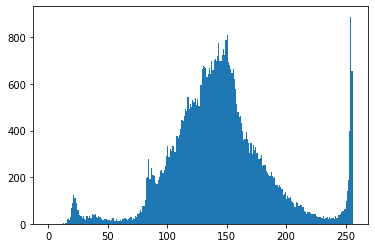

KeyboardInterrupt: ignored

In [12]:
#task 3 
VideoCapture()
eval_js('create()')

CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

isFaceDetect=False
margin = 30

while not isFaceDetect:
  bigrect=[]
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  face = detect(gray, cascade = CascadeFace) # face contains the rectangle
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) # convert image to HSV
  
  #control if a face has been detected
  if len(face)==0: 
    isFaceDetect=False
  else:
    isFaceDetect=True
    
  if len(bigrect)==0 and isFaceDetect: # if bigrect is empty and a face is found
    hsv_roi=hsv[face[0][1]:face[0][3], face[0][0]:face[0][2]]
    bigrect.append(compute_big_rect2(face[0])) # compute bigrect and add it to the list
  
    isDetection=True # set a flag to start camshift
    gray_roi = gray[bigrect[0][1]:bigrect[0][3], bigrect[0][0]:bigrect[0][2]] # compute the region of interest
    hist=cv2.calcHist([hsv_roi], [0], None, [180], [0,180]) # compute the histogram
    plt.hist(gray_roi.ravel(),256,[0,256]) # show the histogram
    plt.show()
  
while isDetection:
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color

  track_window = (bigrect[0][0], bigrect[0][1], bigrect[0][2], bigrect[0][3]) # compute the region of interest (bigrect)
  prob = cv2.calcBackProject([hsv], [0], hist, [0, 256], 1) # compute the probability matrix 
  term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )  # sets some criteria for camshift
  track_box, track_window = cv2.CamShift(prob, track_window, term_crit) # perform camshift over the track_window

  im[:] = prob[...,np.newaxis] # add probability matrix to the image

  draw_rects(im, face, (255, 0, 255))
  draw_rects(im, bigrect, (255, 0, 0), 4) # draw the rectangle

  try:
    cv2.ellipse(im, track_box, (0, 0, 255), 2) # draw the ellipse
  except Exception as e:
    print(e)
    print(track_box)

  eval_js('showimg("{}")'.format(image2byte(im)))

# **Task 4**

In the fourth task the goal is to remove the face so we can detect the hands. I am goin to remove the face from the probability map so the algorithm will look at the picture to find where there is a similar distribution of color as the face and it will find the hands.

In [13]:
#implement
def restrict(rect): #[x1,y1,x2,y2]

  x1=min(image_max_width,rect[0]+restr)
  y1=min(image_max_height,rect[1]+restr)
  x2=max(rect[2]-restr,x1)
  y2=max(rect[3]-restr,y1)
  return [x1,y1,x2,y2]

<IPython.core.display.Javascript object>

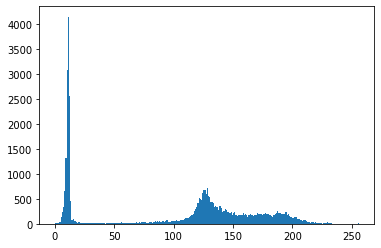

KeyboardInterrupt: ignored

In [14]:
#task 4
VideoCapture()
eval_js('create()')

CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

isFaceDetect=False
margin = 30
restr = 30

while not isFaceDetect:
  bigrect=[] 
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  face = detect(gray, cascade = CascadeFace) # face contains the rectangle
 
  if len(face)==0:
    isFaceDetect=False
  else:
    isFaceDetect=True
    
  if isFaceDetect: # if a face is found
    restricted_face = restrict(face[0])
    hsv_roi=hsv[restricted_face[1]:restricted_face[3], restricted_face[0]:restricted_face[2]] # !!! better to restrict this face for the histogram
    bigrect.append(compute_big_rect2(face[0])) # compute bigrect and add to the list
  
    isDetection=True # set a flag to start camshift
    #gray_roi = gray[bigrect[0][1]:bigrect[0][3], bigrect[0][0]:bigrect[0][2]] # compute the region of interest
    hist=cv2.calcHist([hsv_roi], [0], None, [180], [0,180]) # compute the histogram
    plt.hist(hsv_roi.ravel(),256,[0,256]) # show the histogram
    plt.show()

    track_window = (bigrect[0][0], bigrect[0][1], bigrect[0][2], bigrect[0][3]) # compute the region of interest (bigrect)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 ) # sets some criteria for camshift

while isDetection:
  byte = eval_js('capture()')
  im = byte2image(byte)
  #gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  mask = cv2.inRange(hsv, np.array((0,64,32)), np.array((180,200,200)))

  prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1) # compute the probability matrix 

  for i in range(bigrect[0][0], bigrect[0][2]): # iterates between x1, x2
    for j in range(bigrect[0][1], bigrect[0][3]): # iterates between y1, y2
      prob[j,i]=0 # sets probability matrix to 0 on all points inside bigrect

  prob &= mask

  track_box, track_window = cv2.CamShift(prob, track_window, term_crit) # perform camshift over the track_window
  
  im[:] = prob[...,np.newaxis] # add probability matrix to the image

  draw_rects(im, [restricted_face], (255, 0, 255))
 
  cv2.ellipse(im, track_box, (255, 0, 0), 2) # draw the ellipse
  

  eval_js('showimg("{}")'.format(image2byte(im)))

# **Task 5**

In task 5 the scope is to detect and store the hand as an image in two different sizes: 16x16 and 224x224. 

We start by asking how many pictures you want to take and how many seconds between each picture.

In [15]:
Picture_count=int(input("How many pictures do you want to take? "))# the number of picture to be taken
Time=int(input("How many seconds between each photo? "))
n_images=0 # counter of saved images
saved_images =[]

KeyboardInterrupt: ignored

We continue by actually taking the pictures, cropping them so it takes just the hand and saving them.

<IPython.core.display.Javascript object>

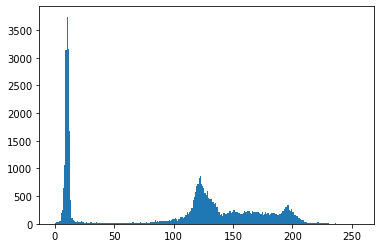

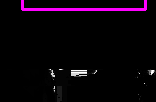

KeyboardInterrupt: ignored

In [20]:
VideoCapture()
eval_js('create()')

CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

isFaceDetect=False
margin = 30
restr = 30

while not isFaceDetect:
  bigrect=[] 
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  face = detect(gray, cascade = CascadeFace) # face contains the rectangle
 
  if len(face)==0:
    isFaceDetect=False
  else:
    isFaceDetect=True
    
  if isFaceDetect: # if a face is found
    restricted_face = restrict(face[0])
    hsv_roi=hsv[restricted_face[1]:restricted_face[3], restricted_face[0]:restricted_face[2]] # !!! better to restrict this face for the histogram
    mask_roi = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
    bigrect.append(compute_big_rect2(face[0])) # compute bigrect and add to the list
  
    isDetection=True # set a flag to start camshift
    hist=cv2.calcHist([hsv_roi], [0], mask_roi, [180], [0,180]) # compute the histogram
    hist=cv2.normalize(hist, hist,  alpha=0, beta=255, norm_type=cv2.NORM_MINMAX) # normalize the histogram 
    plt.hist(hsv_roi.ravel(),256,[0,256]) # show the histogram
    plt.show()

    track_window = (bigrect[0][0], bigrect[0][1], bigrect[0][2], bigrect[0][3]) # compute the region of interest (bigrect)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 ) # sets some criteria for camshift

while isDetection:
  byte = eval_js('capture()')
  im = byte2image(byte)
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  mask = cv2.inRange(hsv, np.array((0,64,32)), np.array((180,200,200)))
  raw_im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
  prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1) # compute the probability matrix 
  

  for i in range(bigrect[0][0], bigrect[0][2]): # iterates between x1, x2
    for j in range(bigrect[0][1], bigrect[0][3]): # iterates between y1, y2
      prob[j,i]=0 # sets probability matrix to 0 on all points inside bigrect

  prob &= mask

  track_box, track_window = cv2.CamShift(prob, track_window, term_crit) # perform camshift over the track_window
  
  im[:] = prob[...,np.newaxis] # add probability matrix to the image

  draw_rects(im, [restricted_face], (255, 0, 255))
 
  #cv2.ellipse(im, track_box, (255, 0, 0), 2) # draw the ellipse

  eval_js('showimg("{}")'.format(image2byte(im)))
  if n_images==Picture_count:
    break
  else:
    time.sleep(Time)
  #we crop the image to have only the hand
  cropped_image = im[int(track_window[1]):int(track_window[1]+track_window[3]), int(track_window[0]):int(track_window[0]+track_window[2])]

  cv2_imshow(cropped_image)
  
  save_image=input("Do you want to save the image Y or N: ")
  #cv2_imshow(cropped_image)
  
  #eval_js('showimg("{}")'.format(image2byte(hand)))
  
  if str.lower(save_image) == 'y':

    saved_images.append(cropped_image)
    print("Picture",n_images+1,"was stored")
    #print(cropped_image)
    n_images+=1
    continue
  else:
    continue


In [21]:
#to see all the saved pictures
for image in saved_images:
  cv2_imshow(image)

NameError: ignored

In the variable img_path I saved the path to the folder containing the pictures, since we made three different datasets I manually changed the folder name when needed.

In [22]:
img_path = "/content/gdrive/MyDrive/Computer Vision Ilaria/images/data1/"

resize_images is used to resize all the images saved into the two sizes, name the pictures with letter+id+size and save them to the folder.

In [23]:
def resize_images(images, letter): 
  sizes = [16, 224]
  for id,image in enumerate(images):
    for size in sizes:
      file_name = letter.upper()+"_" + str(id) +"_"+  str(size) #give the pic a name
      print(file_name) #print the name
      try:
        resized_img = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA) #resize image
      except:
        break
      cv2_imshow(resized_img) #print resized pic
      cv2.imwrite(img_path + file_name + ".jpg", resized_img) #save image to folder


In [24]:
#calling the function, change the letter when needed
resize_images(saved_images, 'N')

NameError: ignored

# **Task 6**

In task 6 we create our dataset, the letters chosen were M, N and W. 


In [25]:
# changes the shape of the array of the 16x16 images and appends it into the text file dataset.txt
def Resize_and_Write(id, letter, dataset):


  #given an id and letter, reads the image and converts it into a list
  img = cv2.imread(img_path +letter+"_" + str(id) + "_16.jpg") #
  res = cv2.resize(img, dsize=(1,256), interpolation=cv2.INTER_CUBIC) # 16x16 to (1,256) 1row | 256 columns
  flat_res = [str(a[0][0]) for a in res] # 1 with 256 elem
  

  is_empty = False
  try:
    with  open("/content/gdrive/MyDrive/Computer Vision Ilaria/" + dataset, "r") as fileobj: # open the dataset in read mode
      if len(fileobj.readlines())==0: # checks if the dataset is empty
        is_empty = True
  except:
    is_empty = True # if the dataset does not exist, set the empty variable to true
  with open("/content/gdrive/MyDrive/Computer Vision Ilaria/" + dataset, "a+") as fileobj: # open the dataset in append mode
    L_list=[letter, *flat_res] # create a list with the letter as first element, followed by all the values of the pixels
    str_list = str(L_list)
    str_list = str_list.replace('\'', '')[1:-1] # remove the quotes and the brackets
    if is_empty:
      fileobj.write(str_list)#Creates file if file doesnt exist/also appends 
    else:
      fileobj.write("\n" + str_list)#Creates file if file doesnt exist/also appends




In [26]:
letters = ["M", "N", "W"]
dataset_1 = "dataset1.txt"
dataset_2 = "dataset2.txt"
dataset_3 = "dataset3.txt"

#change when needed
n_images = 100

Below we just change the name of the dataset as needed.

In [27]:
for i in range(n_images):
  Resize_and_Write(i, "N", dataset_3)

KeyboardInterrupt: ignored

At the end we shuffle the lines of the dataset.

In [ ]:
lines = open('/content/gdrive/MyDrive/Computer Vision Ilaria/dataset2.txt').readlines()
random.shuffle(lines)
open('/content/gdrive/MyDrive/Computer Vision Ilaria/dataset2.txt', 'w').writelines(lines)

# **Task 7**

In the following task we build our MLP. 

In [28]:
dataset_file_path = "/content/gdrive/MyDrive/Computer Vision Ilaria/dataset1.txt"

In [29]:
#The following function takes the dataset file and returns two arrays: samples and letters.
def load_dataset(dataset_file_path):
    a = np.loadtxt(dataset_file_path, delimiter=',', converters={ 0 : lambda ch : ord(ch)-ord('A') })
    samples, letters = a[:,1:], a[:,0] # samples takes all the rows and all the columns except the first column
    # letters: keep only the first column
    return samples, letters

I decided to split the dataset 70% for the training and 30% for the validation.

In [30]:
#here we split the dataset for training and validation
train_ratio = 0.7
samples, letters = load_dataset(dataset_file_path)
n_train_samples = int(len(samples) * train_ratio)
x_train, y_train = samples[:n_train_samples], letters[:n_train_samples] # keeps only the first 70% of rows
x_val, y_val = samples[n_train_samples:], letters[n_train_samples:] # keeps only the last 30%
print(x_train.shape)

(210, 256)


In [ ]:
num_classes = 26 # number of letters
epochs = 100 # number of training s


#here we split the dataset for training and validation
train_ratio = 0.7
samples, letters = load_dataset(dataset_file_path)
n_train_samples = int(len(samples) * train_ratio)
x_train, y_train = samples[:n_train_samples], letters[:n_train_samples] # keeps only the first 70% of rows
x_val, y_val = samples[n_train_samples:], letters[n_train_samples:] # keeps only the last 30%

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 # x_train=x_train/255    normalize the numbers in the interval [0,1]
x_val /= 255
print(x_train.shape[0], 'train samples') # print the number of images
print(x_val.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # converts the prediction letter into a number encoding for that letter
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

model = Sequential() 
model.add(Dense(100, activation='relu', input_shape=(256,))) # add a relu layer
model.add(Dense(100, activation='relu')) # add anothe relu
model.add(Dropout(0.4)) # add a regularizator
model.add(Dense(100, activation='relu')) # add anothe relu
model.add(Dense(100, activation='relu')) # add anothe relu 
model.add(Dropout(0.4)) # add a regularizator
model.add(Dense(num_classes, activation='softmax'))  # add a final softmax layer

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,   
                    epochs=epochs,
                    verbose=1, # if verbose=1 print data for each epoch
                    validation_data=(x_val, y_val)) # train the network
score = model.evaluate(x_val, y_val, verbose=0) # evaluate the obtained model  on the validation set.  #model and dataset
print('Validation loss:', score[0]) # print the loss
print('Validation accuracy:', score[1]) # print the accuracy

210 train samples
90 test samples
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 100)               25700     
                                                                 
 dense_66 (Dense)            (None, 100)               10100     
                                                                 
 dropout_29 (Dropout)        (None, 100)               0         
                                                                 
 dense_67 (Dense)            (None, 100)               10100     
                                                                 
 dense_68 (Dense)            (None, 100)               10100     
                                                                 
 dropout_30 (Dropout)        (None, 100)               0         
                                                                 
 dense_69 (Dense)  

After I trained the model, I save the model and weights in two files in the shared folder.

In [31]:
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Computer Vision Ilaria/model1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Computer Vision Ilaria/model1_weights.h5")
print("Saved model to disk")

NameError: ignored

### **Comparison**

After training the 3 models we are going to see how each models performs on each dataset.

In [32]:
def evaluate_model(path, model):
  train_ratio = 0.7
  samples, letters = load_dataset(path) # load the dataset
  n_train_samples = int(len(samples) * train_ratio)
  x_train, y_train = samples[:n_train_samples], letters[:n_train_samples] # keeps only the first 70% of rows
  x_val, y_val = samples[n_train_samples:], letters[n_train_samples:] # keeps only the last 30%
  x_train = x_train.astype('float32')
  x_val = x_val.astype('float32')
  x_train /= 255 # x_train=x_train/255    normalize the numbers in the interval [0,1]
  x_val /= 255
  
  print(x_train.shape[0], 'train samples') # print the number of images
  print(x_val.shape[0], 'test samples')

  # convert class vectors to binary class matrices
  y_train = tf.keras.utils.to_categorical(y_train, num_classes) # converts the prediction letter into a number encoding for that letter
  y_val = tf.keras.utils.to_categorical(y_val, num_classes)

  score = model.evaluate(x_val, y_val, verbose=0) # evaluate the model on the validation set.  #model and dataset
  print('Validation loss:', score[0]) # print the loss
  print('Validation accuracy:', score[1]) # print the accuracy

In [ ]:
from keras.models import model_from_json
g_path = "/content/gdrive/MyDrive/Computer Vision Ilaria/"
# load json and create model
json_file = open(g_path+'model3.json', 'r') 
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.summary()
# load weights into new model
loaded_model.load_weights(g_path+"model3_weights.h5")

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

dataset_file_paths = [g_path+"dataset1.txt", g_path+"dataset2.txt", g_path+"dataset3.txt"]
for path in dataset_file_paths:
  print(path)
  evaluate_model(path, loaded_model)

Reminder:

Dataset 1: 3 letters with equal number of pictures and a lot of variability \
Dataset 2: 3 letters with unbalanced number of pictures (50 - 100 -150) and a lot of variability \
Dataset 3: 3 letters with equal number of pictures and one of them with no variability (N)

**Model 1**

**dataset1.txt** \
210 train samples - 90 test samples \
Validation loss: 1.4552514553070068 \
Validation accuracy: 0.6555555462837219

**dataset2.txt** \
244 train samples - 106 test samples \
Validation loss: 0.9062689542770386 \
Validation accuracy: 0.8301886916160583

**dataset3.txt** \
210 train samples - 90 test samples \
Validation loss: 0.669061005115509 \
Validation accuracy: 0.8444444537162781

*Model 1 performs best with dataset 2 and 3, this is probably due to the unbalanced number of pictures in dataset 2 and lack of variability in dataset 3.*


**Model 2**

**dataset1.txt** \
210 train samples - 90 test samples \
Validation loss: 1.7094557285308838 \
Validation accuracy: 0.7666666507720947 

**dataset2.txt** \
244 train samples - 106 test samples \
Validation loss: 0.9224103689193726 \
Validation accuracy: 0.8396226167678833 

**dataset3.txt** \
210 train samples - 90 test samples \
Validation loss: 1.2521220445632935 \
Validation accuracy: 0.7555555701255798

*Model 2 performs best with its own dataset. To make it simple, it's probably easier for the model to guess the right letter when one letter has such an high number of pictures compared to the others. There's a lot more probability that it's going to be the letter with the highest number of pictures.*

**Model 3**

**dataset1.txt** \
210 train samples - 90 test samples \
Validation loss: 1.2043957710266113 \
Validation accuracy: 0.7888888716697693

**dataset2.txt** \
244 train samples - 106 test samples \
Validation loss: 1.269263744354248 \
Validation accuracy: 0.7641509175300598

**dataset3.txt** \
210 train samples - 90 test samples \
Validation loss: 1.8944649696350098 \
Validation accuracy: 0.699999988079071

*Model 3 performs best with datase 1 and 2.* 

# **Task 8**

Test phase: for the test phase I am going to use model 1. 

In [33]:
# load json and create model
json_file = open('/content/gdrive/MyDrive/Computer Vision Ilaria/model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json) #not used
# load weights into new model
loaded_model.load_weights("/content/gdrive/MyDrive/Computer Vision Ilaria/model1_weights.h5")

In [34]:
prediction = loaded_model.predict(x_train[0:1,:]) # where hand_image is the probability image of your hand of size (1,256)
prediction = prediction.argmax()
predicted_letter = chr(ord('A') + prediction)
print(predicted_letter)

1/1 [==============================] - 0s 242ms/step
M


I show the hand to the camera doing some of the letters with which I trained the model.\
The program finds my hand, generates a gray scale image of the probability of your hand, resize the image to (1,256).\
Pass this image to the loaded model and predict.\
I show the prediction with a text in the video.

<IPython.core.display.Javascript object>

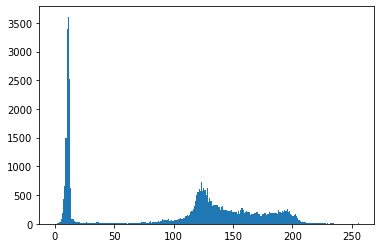

1/1 [==============================] - 0s 15ms/step


In [ ]:
VideoCapture()
eval_js('create()')

CascadeFace = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

isFaceDetect=False
margin = 30
restr = 30
n_images = 0
Time = 1
Picture_count = 1000
while not isFaceDetect:
  bigrect=[] 
  byte = eval_js('capture()')
  im = byte2image(byte)
  gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert the image into GRAY
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  face = detect(gray, cascade = CascadeFace) # face contains the rectangle
 
  if len(face)==0:
    isFaceDetect=False
  else:
    isFaceDetect=True
    
  if isFaceDetect: # if a face is found
    restricted_face = restrict(face[0])
    hsv_roi=hsv[restricted_face[1]:restricted_face[3], restricted_face[0]:restricted_face[2]] # !!! better to restrict this face for the histogram
    mask_roi = cv2.inRange(hsv_roi, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
    bigrect.append(compute_big_rect2(face[0])) # compute bigrect and add to the list
  
    isDetection=True # set a flag to start camshift
    #gray_roi = gray[bigrect[0][1]:bigrect[0][3], bigrect[0][0]:bigrect[0][2]] # compute the region of interest
    hist=cv2.calcHist([hsv_roi], [0], mask_roi, [180], [0,180]) # compute the histogram
    hist=cv2.normalize(hist, hist,  alpha=0, beta=255, norm_type=cv2.NORM_MINMAX) # normalize the histogram 
    plt.hist(hsv_roi.ravel(),256,[0,256]) # show the histogram
    plt.show()

    track_window = (bigrect[0][0], bigrect[0][1], bigrect[0][2], bigrect[0][3]) # compute the region of interest (bigrect)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 ) # sets some criteria for camshift

while isDetection:
  byte = eval_js('capture()')
  im = byte2image(byte)
  hsv =  cv2.cvtColor(im, cv2.COLOR_RGB2HSV) #convert image to color
  mask = cv2.inRange(hsv, np.array((0,64,32)), np.array((180,200,200)))
  raw_im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
  prob = cv2.calcBackProject([hsv], [0], hist, [0, 180], 1) # compute the probability matrix 

  for i in range(bigrect[0][0], bigrect[0][2]): # iterates between x1, x2
    for j in range(bigrect[0][1], bigrect[0][3]): # iterates between y1, y2
      prob[j,i]=0 # sets probability matrix to 0 on all points inside bigrect

  prob &= mask

  track_box, track_window = cv2.CamShift(prob, track_window, term_crit) # perform camshift over the track_window 
  im[:] = prob[...,np.newaxis] # add probability matrix to the image
  cv2.ellipse(im, track_box, (255, 0, 0), 2) # draw the ellipse
  
  if n_images==Picture_count:
    break
  else:
    time.sleep(Time)
  #we crop the image to have only the hand
  cropped_image = im[int(track_window[1]):int(track_window[1]+track_window[3]), int(track_window[0]):int(track_window[0]+track_window[2])]
  
  #save_image=input("Do you want to save the image Y or N: ")
  resized_img = cv2.resize(cropped_image, (16, 16), interpolation = cv2.INTER_AREA)
  resized_img = cv2.resize(resized_img, dsize=(1,256), interpolation=cv2.INTER_CUBIC)
  resized_img = np.array([str(a[0][0]) for a in resized_img])
  resized_img=resized_img.astype('float32')
  resized_img /= 255.0
  #print(resized_img[np.newaxis, :].shape)
  prediction = loaded_model.predict(resized_img[np.newaxis, :]) # where hand_image is the probability image of your hand of size (1,256)
  prediction = prediction.argmax()
  predicted_letter = chr(ord('A') + prediction)

  font = cv2.FONT_HERSHEY_SIMPLEX
  cv2.putText(im, predicted_letter, (int(track_window[0]), int(track_window[1])), font, 1, (0, 255, 255), 2, cv2.LINE_4)

  eval_js('showimg("{}")'.format(image2byte(im)))
  n_images+=1
